# Raster analysis - Advanced concepts

## Access Landsat imagery

In [1]:
from arcgis.gis import GIS

In [2]:
gis = GIS()

In [3]:
landsat_item = gis.content.search('Multispectral Landsat', 'Imagery Layer', outside_org=True)[0]

In [4]:
landsat_item

<Item title:"Pansharpened Landsat" type:Imagery Layer owner:esri>

## View Landsat imagery layer item description

In [5]:
from IPython.display import HTML
HTML(landsat_item.description)

## Access the layers available with the Landsat Imagery Layer item

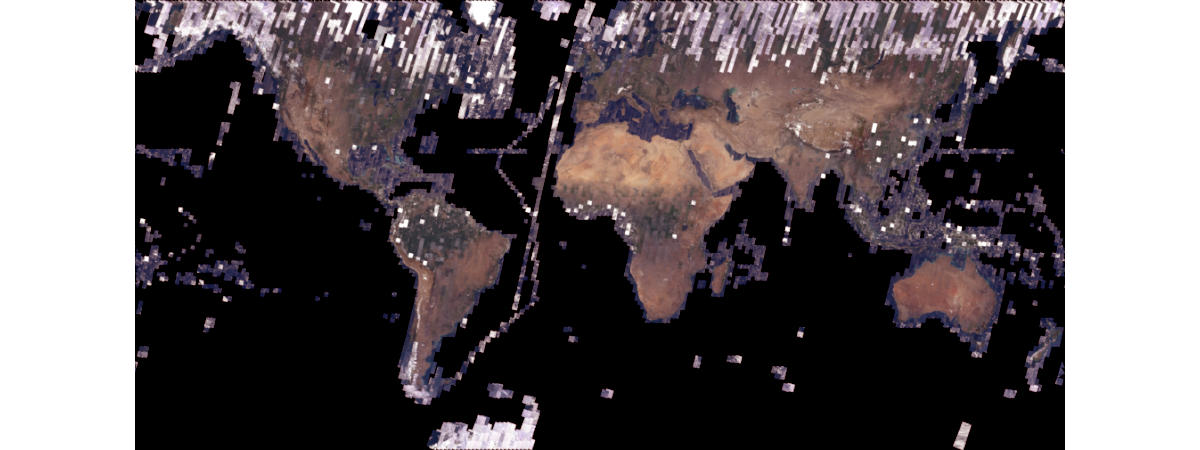

In [6]:
landsat = landsat_item.layers[0]
landsat

## Explore different wavelength bands

In [7]:
import pandas as pd

In [8]:
pd.DataFrame(landsat.key_properties()['BandProperties'])

""
0
1
2


## Visualize the layer in the map widget

In [9]:
m = gis.map('Redlands, CA')
m

MapView(layout=Layout(height='400px', width='100%'))

In [10]:
m.add_layer(landsat)

## Apply built-in raster functions

In [11]:
for rasterFunc in landsat.properties.rasterFunctionInfos:
    print(rasterFunc.name)

Pansharpened Enhanced with DRA
Pansharpened Natural Color
None


In [12]:
from arcgis.raster.functions import apply

In [13]:
color_infrared = apply(landsat, 'Color Infrared with DRA')

In [14]:
m2 = gis.map('Redlands, CA')
m2.add_layer(color_infrared)
m2

MapView(layout=Layout(height='400px', width='100%'))

## Interactive raster processing in Jupyter Notebook

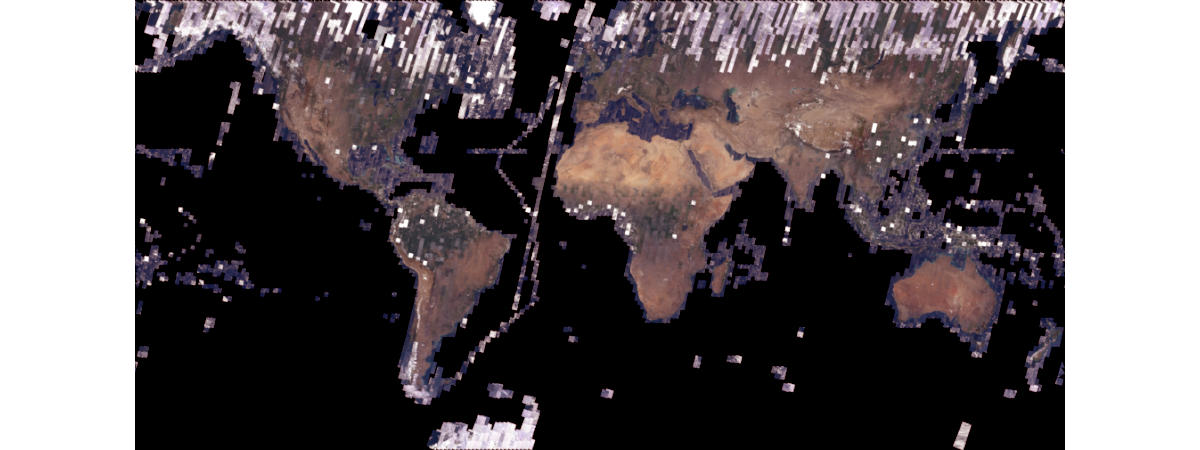

In [15]:
color_infrared

### Setting an area of interest

In [16]:
from arcgis.geocoding import geocode
area = geocode('Redlands, CA', out_sr=landsat.properties.spatialReference)[0]

In [17]:
color_infrared.extent = area['extent']

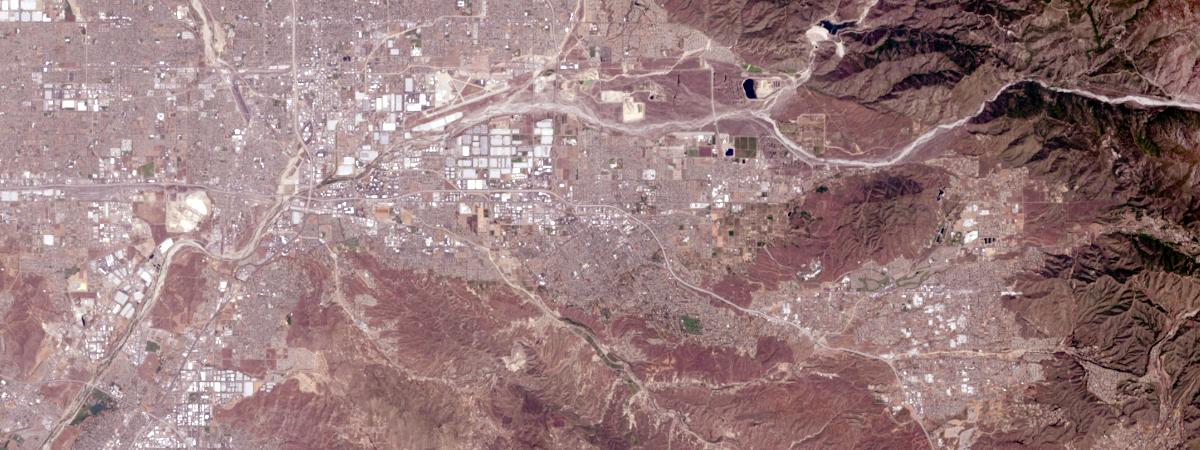

In [18]:
color_infrared

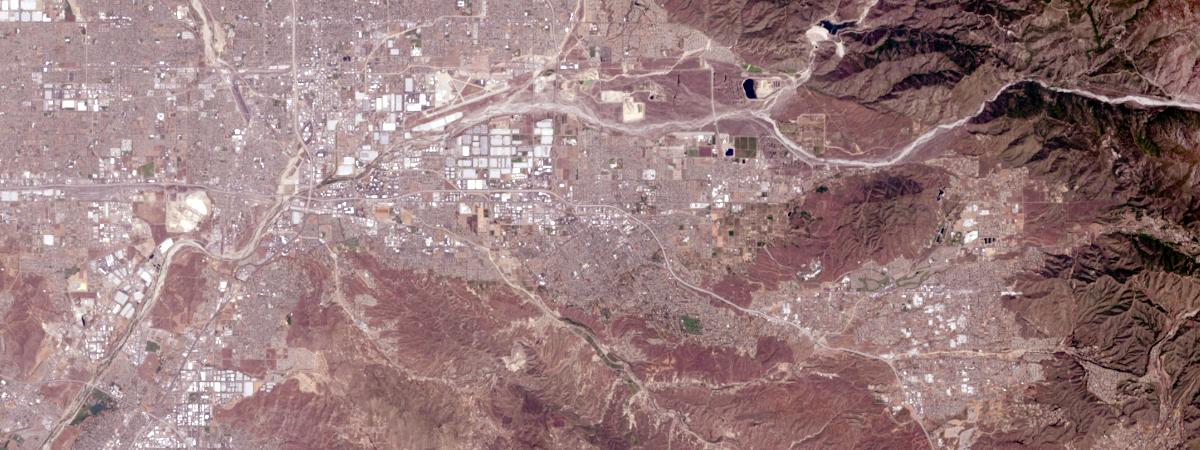

In [19]:
landsat.extent = area['extent']
landsat

## Exporting Images from Imagery Layer

In [20]:
from IPython.display import Image

In [21]:
image = landsat.export_image(bbox=area['extent'], size=[1200,450], f='image')

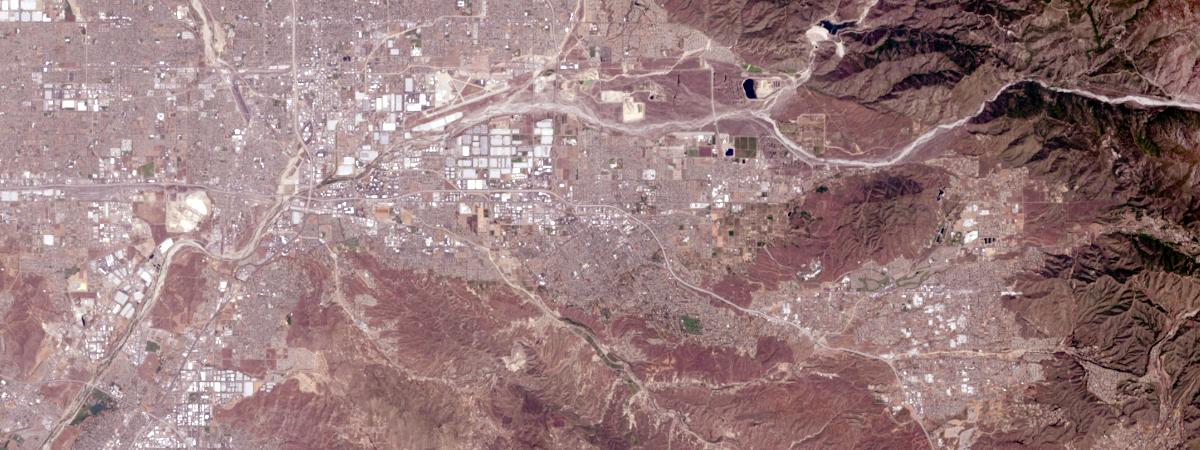

In [22]:
Image(image)

In [23]:
savedimage = landsat.export_image(bbox=area['extent'],
                                  size=[1200,450],
                                  f='image',
                                  save_folder='.',
                                  save_file='image.jpg')

In [24]:
savedimage

'./image.jpg'

In [25]:
from IPython.display import Image

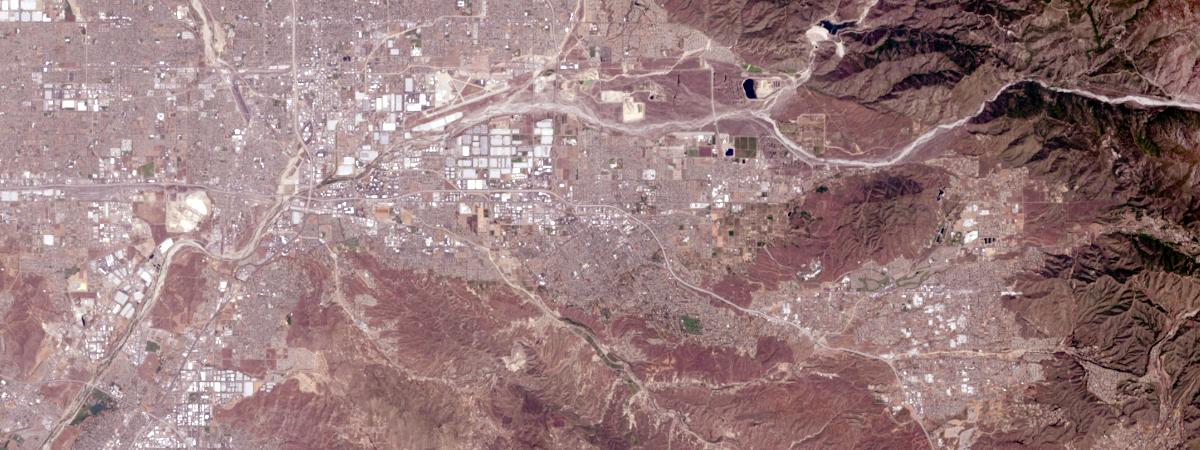

In [26]:
Image(filename=savedimage, width=1200, height=450)

## Exporting images from an imagery layer to which a raster function has been applied

In [27]:
color_infrared = apply(landsat, 'Color Infrared with DRA')

In [28]:
image = color_infrared.export_image(bbox=area['extent'], size=[1200, 450], f='image')

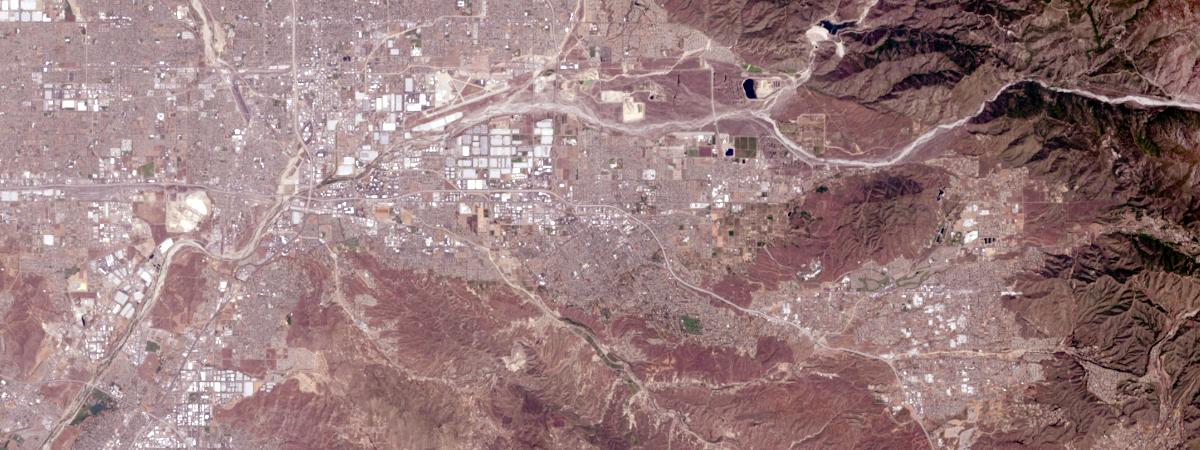

In [29]:
Image(image)

## Vegetation Index

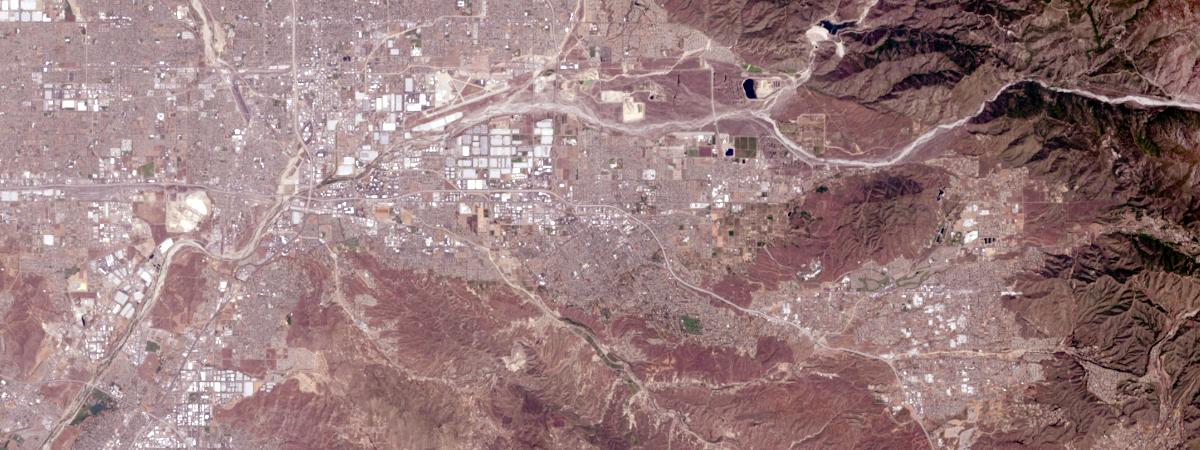

In [30]:
ndvi_colorized = apply(landsat, 'NDVI Colorized')
ndvi_colorized

## Custom Bands

In [31]:
from arcgis.raster.functions import stretch, extract_band

In [32]:
naturalcolor = stretch(extract_band(landsat, [3, 2, 1]),
                       stretch_type='percentclip',
                       min_percent=0.1,
                       max_percent=0.1,
                       gamma=[1, 1, 1],
                       dra=True)

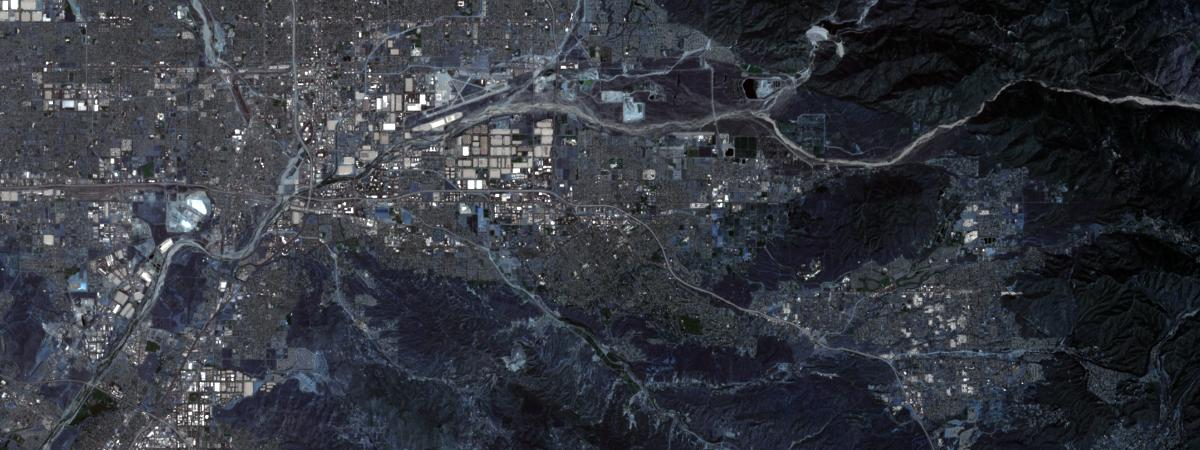

In [33]:
naturalcolor

## Image Attributes

In [34]:
import arcgis
g = arcgis.geometry.Geometry(area['extent'])

In [35]:
samples = landsat.get_samples(g,
                              sample_count=50,
                              out_fields='AcquisitionDate,OBJECTID,GroupName,Category,SunAzimuth,SunElevation,CloudCover')

In [36]:
samples[0]

{'location': {'x': -13051569.97725714,
  'y': 4044790.7833781266,
  'spatialReference': {'wkid': 102100, 'latestWkid': 3857}},
 'locationId': 0,
 'value': '1639 1473 1427',
 'rasterId': 1249137,
 'resolution': 15,
 'attributes': {'AcquisitionDate': 1560018116279,
  'OBJECTID': 1249137,
  'GroupName': 'LC80400362019159LGN00_MTL',
  'Category': 1,
  'SunAzimuth': 116.9961,
  'SunElevation': 68.19199,
  'CloudCover': 0.0006},
 'values': [1639.0, 1473.0, 1427.0]}

In [37]:
import datetime
value = samples[0]['attributes']['AcquisitionDate']
datetime.datetime.fromtimestamp(value / 1000).strftime("Acquisition Date: %d %b, %Y")

'Acquisition Date: 08 Jun, 2019'

In [38]:
pd.DataFrame(samples[0]['attributes'], index=[0])

,AcquisitionDate,OBJECTID,GroupName,Category,SunAzimuth,SunElevation,CloudCover
0,1560018116279,1249137,LC80400362019159LGN00_MTL,1,116.9961,68.19199,0.0006


## Spectral profile from the sampled values at a location

In [39]:
m3 = gis.map('Redlands, CA')
m3

MapView(layout=Layout(height='400px', width='100%'))

In [40]:
m3.add_layer(landsat)

In [41]:
from bokeh.models import Range1d
from bokeh.plotting import figure, show, output_notebook
from IPython.display import clear_output
output_notebook()

def get_samples(mw, g):
    clear_output()
    m.draw(g)
    samples = landsat.get_samples(g, pixel_size=30)
    values = samples[0]['value']
    vals = [float(int(s) / 100000) for s in values.split(' ')]
    
    x = ['1', '2', '3', '4', '5', '6', '7', '8']
    y = vals
    p = figure(title="Spectral Profile", x_axis_label='Spectral Bands', y_axis_label='Data Values', width=600, height=300)
    p.line(x, y, legend="Selected Point", line_color="red", line_width=2)
    p.circle(x, y, line_color="red", fill_color="white", size=8)
    p.y_range=Range1d(0, 1.0)

    show(p)
    
print('Click anywhere on the map to plot the spectral profile for that location.')
m.on_click(get_samples)

Loading BokehJS ...

Click anywhere on the map to plot the spectral profile for that location.


## Clipping to an area of interest

In [42]:
from arcgis.geometry import Geometry, buffer

In [43]:
poly = buffer(geometries=[Geometry(area['location'])],
              in_sr=102100,
              distances=6000,
              unit='esriMeters')[0]

In [44]:
from arcgis.raster.functions import clip

In [45]:
redclip = clip(landsat, poly)

In [46]:
m4 = gis.map('Redlands, CA')

In [47]:
m4

MapView(layout=Layout(height='400px', width='100%'))

In [48]:
m4.add_layer(redclip)

## Select images by where clause, geometry and time range

In [49]:
selected = landsat.filter_by(where="(Category = 1) AND (CloudCover <=0.10) AND (WRS_Row = 36)",
                             geometry=arcgis.geometry.filters.intersects(area['extent']))

In [50]:
fs = selected.query(out_fields="AcquisitionDate, GroupName, Best, CloudCover, WRS_Row, Month, Name",
                    return_geometry=True,
                    return_distinct_values=False,
                    order_by_fields="AcquisitionDate")

In [51]:
df = fs.sdf
df.head()

,AcquisitionDate,Best,CloudCover,GroupName,Month,Name,OBJECTID,SHAPE,Shape_Area,Shape_Length,WRS_Row
0,2000-04-24 00:00:00.000000000,88960036,0.0000,p040r036_7x20000424,4,p040r036_7x20000424_PS,664535,"{""rings"": [[[-12872961.873599999, 4197538.7916...",4.600983e+10,858608.456217,36
1,2005-05-24 00:00:00.000000000,79960036,0.0000,L7040036_03620050524,5,L7040036_03620050524_PS,673670,"{""rings"": [[[-12867140.4332, 4198647.7443], [-...",4.766887e+10,874086.578684,36
2,2014-04-07 18:22:17.313999891,84960036,0.0045,LC80400362014097LGN00_MTL,4,LC80400362014097LGN00,84426,"{""rings"": [[[-12868346.0088, 4199764.671300001...",5.109227e+10,904494.753605,36
3,2014-09-30 18:22:18.497999907,80960036,0.0043,LC80400362014273LGN00_MTL,9,LC80400362014273LGN00,84427,"{""rings"": [[[-12863947.662999999, 4199535.1133...",5.110416e+10,904595.143358,36
4,2014-10-16 18:22:23.338000059,82960036,0.0194,LC80400362014289LGN00_MTL,10,LC80400362014289LGN00,84428,"{""rings"": [[[-12865784.5616, 4199562.156599998...",5.110299e+10,904595.590773,36


In [52]:
df.shape

(72, 11)

In [53]:
df['Time'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df['Time'].head(10)

0   2000-04-24 00:00:00.000000000
1   2005-05-24 00:00:00.000000000
2   2014-04-07 18:22:17.313999891
3   2014-09-30 18:22:18.497999907
4   2014-10-16 18:22:23.338000059
5   2014-11-17 18:22:20.786999941
6   2014-12-19 18:22:16.836999893
7   2015-02-05 18:22:04.519000052
8   2015-03-09 18:21:48.729000092
9   2015-03-25 18:21:40.197999954
Name: Time, dtype: datetime64[ns]

## Resolving overlapping pixels in selected rasters

In [54]:
m5 = gis.map('Redlands, CA', 7)
display(m5)
m5.add_layer(selected.last())

MapView(layout=Layout(height='400px', width='100%'), zoom=7.0)

In [55]:
m6 = gis.map('Redlands, CA', 7)
display(m6)
m6.add_layer(selected.first())

MapView(layout=Layout(height='400px', width='100%'), zoom=7.0)

## Change Detection

In [56]:
old = landsat.filter_by('OBJECTID=1139')

In [57]:
new = landsat.filter_by('OBJECTID=463490')

## Difference Image

In [58]:
from arcgis.raster.functions import *

In [59]:
diff = stretch(composite_band([ndvi(old, '5 4'), ndvi(new, '5 4'), ndvi(old, '5 4')]),
               stretch_type='stddev',
               num_stddev=3,
               min=0,
               max=255,
               dra=True,
               astype='u8')
diff

## Applying a threshold mask

In [60]:
ndvi_diff = ndvi(new, '5 4') - ndvi(old, '5 4')

In [61]:
ndvi_diff

In [62]:
threshold_val = 0.1

In [63]:
masked = colormap(remap(ndvi_diff,
                        input_ranges=[threshold_val, 1],
                        output_values=[1],
                        no_data_ranges=[-1, threshold_val], astype='u8'),
                  colormap=[[1, 124, 252, 0]], astype='u8')

Image(masked.export_image(bbox=area['extent'], size=[1200,450], f='image'))

FileNotFoundError: No such file or directory: '{"error":{"code":400,"message":"Invalid or missing input parameters.","details":[]}}'

FileNotFoundError: No such file or directory: '{"error":{"code":400,"message":"Invalid or missing input parameters.","details":[]}}'

<IPython.core.display.Image object>

In [64]:
m7 = gis.map('Redlands, CA')
m7

MapView(layout=Layout(height='400px', width='100%'))

In [65]:
m7.add_layer(diff)

In [66]:
m7.add_layer(masked)

## Persisting your analysis for visualizaion or analysis

In [67]:
layer = masked.save('Test_viz_layer3', for_viz=True)

RuntimeError: You need to be signed in to a GIS to create Items

In [68]:
layer

NameError: name 'layer' is not defined